# Priors

A powerful aspect of a fully bayesian analysis approach is the possibility of explicitly stating any prior expectations about the parameter values based on previous knowledge. 

The most typical use of the IMAGINE employs Pipeline objects based on the Nested Sampling approach (e.g. Ultranest). This requires the priors to be specified as a *prior transform function*, that is: a mapping between uniformly distributed values to the actual distribution. The IMAGINE prior classes can handle this automatically and output either the *probability density function* (PDF) or the *prior transform function*, depending on the needs of the chosen sampler.

## Marginal prior distributions

We will first approach the case where we only have access independent prior information for each parameter (i.e. there is no prior information on correlation between parameters).  The `GeneralPrior` class helps constructing an IMAGINE prior from either: a know prior PDF, or a previous sampling of the parameter space. 

### Prior from a sample

To illustrate this, we will first construct a sample associated with a hypothetical parameter. To keep things simple but still illustrative, we construct this combining a uniform distribution and a normal distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import imagine as img

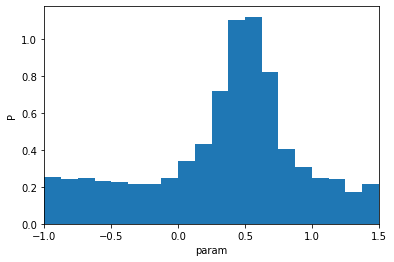

In [2]:
sample = np.concatenate([np.random.random_sample(2000),
                         np.random.normal(loc=0.6, scale=0.07, size=1500) ])
sample = sample*2.5-1
sample *= u.microgauss
plt.hist(sample.value, bins=20, density=True)
plt.ylabel('P'); plt.xlabel('param'); plt.xlim(-1,1.5);

This distribution could be the result of a previous inference exercise 
(i.e. a previously computed marginalised posterior distribution). 

From it, we can construct our prior using the `GeneralPrior` class. 
Lets say that, for some reason, we are only interested in the interval 
$[-0.9,1.5]$ (say, for example, $p=-1$ is unphysical), this can be accounted for 
with the argument `interval`.

In [3]:

interval = (-0.9,1.5)*u.microgauss

prior_param = img.priors.GeneralPrior(samples=sample, interval=interval)

del sample # to save memory

At this point we can inspect the PDF to see what we have.

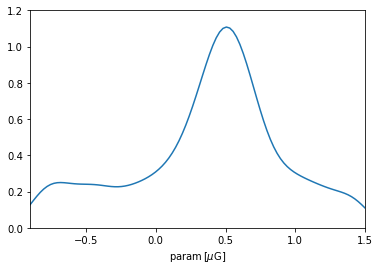

In [4]:
p = np.linspace(*interval, 100)
plt.plot(p, prior_param.pdf_unscaled(p))
plt.xlim(*interval.value); plt.ylim(0,1.2); plt.xlabel(r'param$\,[\mu\rm G]$');

A cautionary note: the KDE used in intermediate calculation tends so smoothen the distribution and forces a slight decay close to the endpoints (reflecting the fact that a Gaussian kernel was employed). For most practical applications,
this is not a big problem: one can control the degree of smoothness through the argument `bw_method` while initializing `GeneralPrior`, and the range close to endpoints are typically uninteresting. But it is recommended to always check the PDF of a prior generated from a set of samples.

### Prior from a known PDF

Alternatively, when one knows the analytic shape of given PDF, one can instead supply a function to `GeneralPrior`. In this case, the shape of the original function is generally respected. For example:

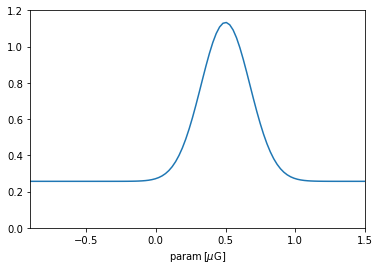

In [5]:
def example_pdf(y):
    x = y.to(u.microgauss).value # Handles units
    uniform_part = 1    
    sigma = 0.175; mu = 0.5
    gaussian_part = 1.5*( 1/(sigma * np.sqrt(2 * np.pi)) 
                         * np.exp( - (x - mu)**2 / (2 * sigma**2) ))
    return uniform_part + gaussian_part

prior_param = img.priors.GeneralPrior(pdf_fun=example_pdf, interval=interval)

plt.plot(p, prior_param.pdf_unscaled(p))
plt.xlim(*interval.value); plt.ylim(0,1.2); plt.xlabel(r'param$\,[\mu\rm G]$');

Once the prior object was constructed, the IMAGINE Pipeline object uses it as the mapping above described to sample new paramters. Let us illustrate this concretely and check whether the prior is working (note that the Prior will
operate on scaled parameters, i.e. with values in the interval $[0,1]$).

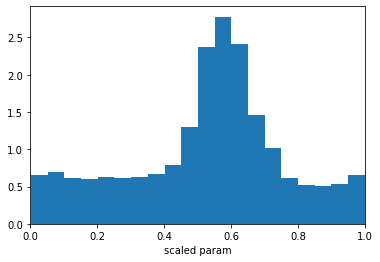

In [6]:
uniform_sample = np.random.random_sample(2000)
sampled_values = prior_param(uniform_sample)

plt.hist(sampled_values, bins=20, density=True)
plt.xlabel('scaled param'); plt.xlim(0,1);

### Prior from scipy.stats distribution
We now demonstrate a helper class which allows to easily construct priors from one [scipy.stats distributions](https://docs.scipy.org/doc/scipy/reference/stats.html). Lets say we wanted impose a [chi](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi.html) prior distribution for a 
given parameter, we can achive this using the `scipyPrior` class.

In [7]:
import scipy.stats 
muG = u.microgauss
chiPrior = img.priors.ScipyPrior(scipy.stats.chi, 3, loc=-10*muG, 
                                 scale=5*muG, interval=[-20,10]*muG)

The first argument of `img.priors.scipyPrior` is an instance of `scipy.stats.rv_continuous`, this is followed by any args required by the scipy distribution (in this specific case, `3` is the number of degrees of freedom in the chi-distribution). The keyword arguments loc and scale have the same meaning as in the `scipy.stats` case, and interval tells maximum and minimum parameter values that will be considered.

Let us check that this works, ploting the PDF and an histogram of parameter values sampled from the prior.

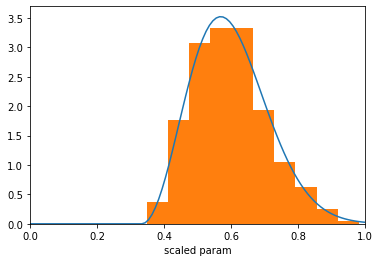

In [8]:
# Plots the PDF associated with this prior
t = np.linspace(0,1,100)
plt.plot(t, chiPrior.pdf(t))
# Plots the distribution of values constructed using this prior
x = np.random.random_sample(2000)
plt.hist(chiPrior(x), density=True);
plt.xlabel('scaled param'); plt.xlim(0,1);

## Joint prior distributions

In the more general (and perhaps interesting) case, the priors are not expressed for individual parameters (i.e. marginalized), but instead as joint distributions.  This feature is still *under development*.